In [1]:
import os

import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from IPython.display import clear_output
from torch.utils.data.sampler import SubsetRandomSampler

from preprocess import FermiDataset, RandomCrop, ToTensor, OneHotEncoding
%matplotlib inline

plt.style.use('ggplot')
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


### Data preprocessing

In [2]:
def show_fermi(ax, i, image, mask):
    ax[0][i].imshow(image.reshape(image.shape[:2]))
    ax[1][i].imshow(mask.reshape(image.shape[:2]))

In [3]:
data_transform = transforms.Compose([
        RandomCrop(40),
        OneHotEncoding(2),
        ToTensor()
])
path = '/notebooks/anton/course/data'
dset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                    points_path=os.path.join(path, 'train_data/y'), transform=data_transform)

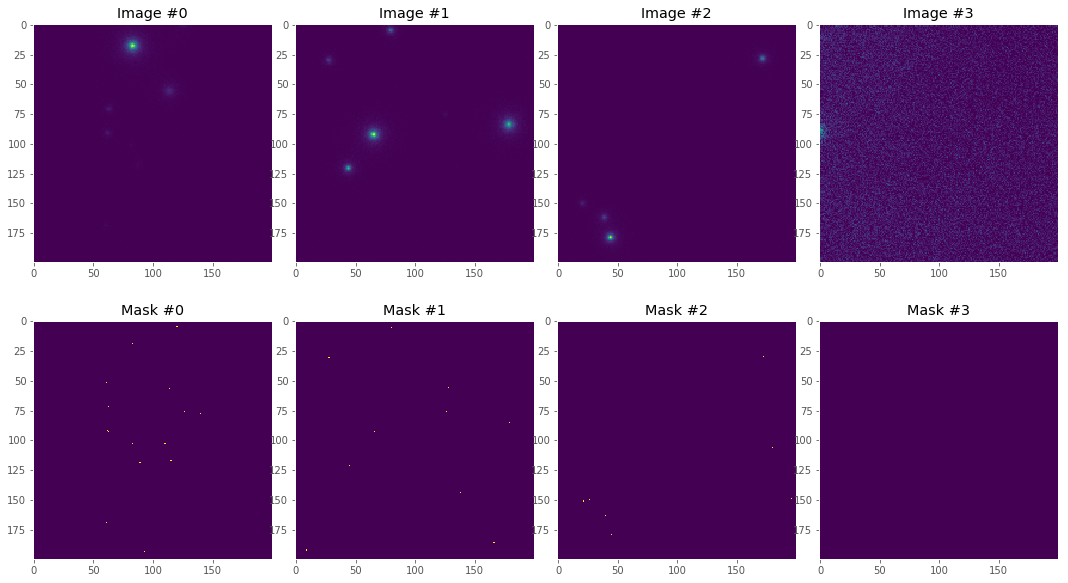

In [4]:
data_transform = transforms.Compose([
        RandomCrop(40),
        ToTensor()
])

dset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                    points_path=os.path.join(path, 'train_data/y'))

_, ax = plt.subplots(2, 4, figsize=(15, 15))
for i in range(4):
    sample = dset[i]
    plt.tight_layout()
    ax[0][i].grid()
    ax[0][i].set_title('Image #{}'.format(i))
    ax[1][i].grid()
    ax[1][i].set_title('Mask #{}'.format(i))
    
    show_fermi(ax, i,  *sample)
    plt.subplots_adjust(wspace=0.1, hspace=-0.6)

In [8]:
SIZE = 100
data_transform = transforms.Compose([
        RandomCrop(SIZE),
        OneHotEncoding(2),
        ToTensor()
])

train_dataset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                             points_path=os.path.join(path, 'train_data/y'),
                             transform=data_transform)
test_dataset = FermiDataset(images_path=os.path.join(path, 'train_data/x'),
                            points_path=os.path.join(path, 'train_data/y'),
                            transform=data_transform)

data_loader = {phase: torch.utils.data.DataLoader(dataset,
                                                  batch_size=20, shuffle=True,
                                                  num_workers=4)
               for phase, dataset in zip(['train', 'test'], [train_dataset, test_dataset])}

dataset_sizes = {phase: len(dataset) for phase, dataset in zip(['train', 'test'], 
                                                               [train_dataset, test_dataset])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model initialization

In [22]:
class ConvNet(nn.Module):
    def __init__(self, device):
        self.device = device
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv4 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv6 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1).to(self.device)

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs)).to(self.device)
        x = F.relu(self.conv2(x)).to(self.device)
        x = F.relu(self.conv3(x)).to(self.device)
        x = F.relu(self.conv4(x)).to(self.device)
        x = F.relu(self.conv5(x)).to(self.device)
        x = self.conv6(x).to( self.device)
        return x

### Training process

In [23]:
def plot_stats(loss, acc, name):
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(loss)
    ax[0].set_title(name + ' loss')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Loss')
    ax[1].plot(acc)
    ax[1].set_title(name + ' quality')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Quality')
    plt.show()

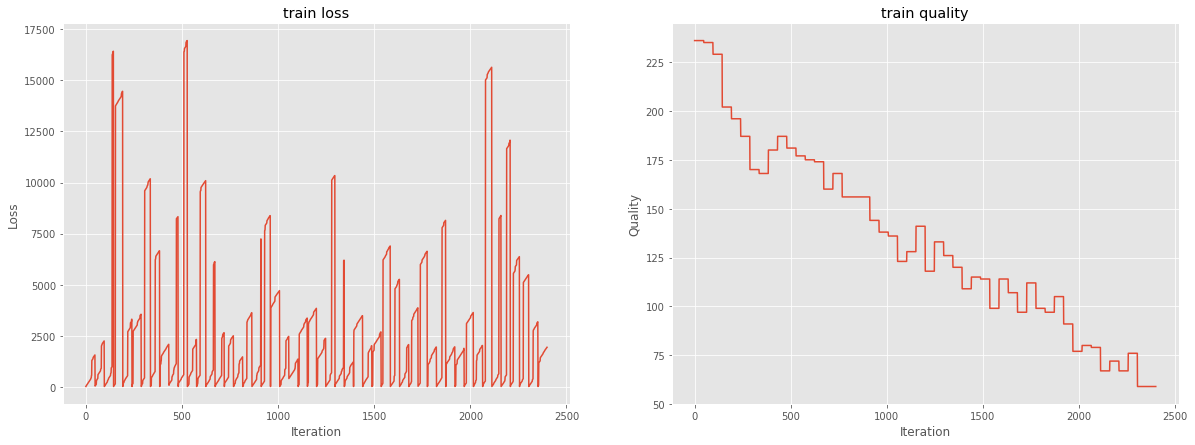

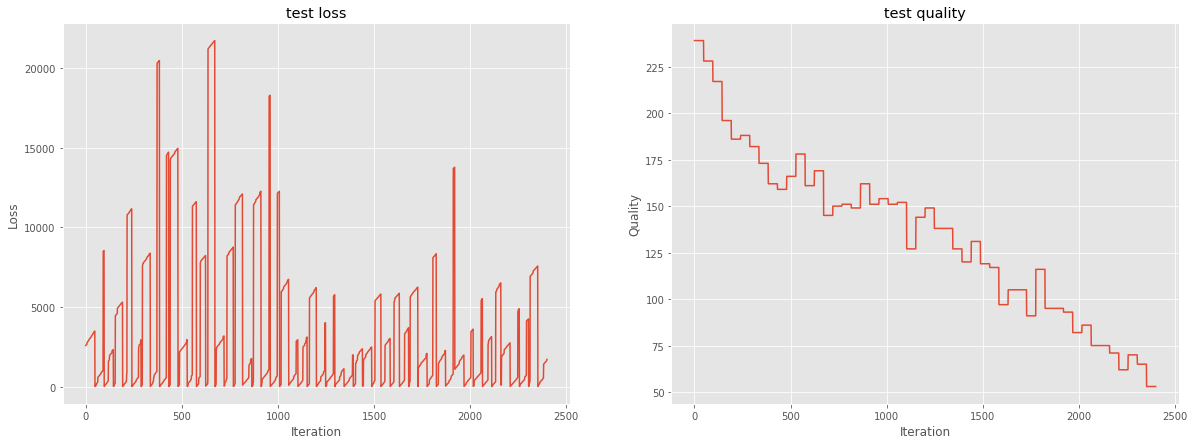

test Loss: 1.8123 Acc: 0.0560


In [24]:
from tqdm import tqdm

global_loss_train = []
global_acc_train = []

global_loss_test = []
global_acc_test = []

model = ConvNet(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.001)#optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)#
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1., 50.])).to(device)
num_epochs = 50
sigm = torch.nn.Sigmoid()

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
#             scheduler.step()
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in data_loader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                outputs = outputs.transpose(3, 1)
                preds = sigm(outputs)

                labels = labels.transpose(3, 1)

                outputs = outputs.to(device)
                labels = labels.to(device)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                class_pred = (preds[:, :, :, 1] > 0.5).to(torch.int8)
                class_true = (labels[:, :, :, 1]).to(torch.int8)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(class_pred & class_true)
            
            if phase == 'train':
                global_loss_train.append(running_loss)
                global_acc_train.append(running_corrects)
            
            if phase == 'test':
                global_loss_test.append(running_loss)
                global_acc_test.append(running_corrects)

        clear_output()

        plot_stats(global_loss_train, global_acc_train, 'train')
        plot_stats(global_loss_test, global_acc_test, 'test')

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        # deep copy the model
#         if phase == 'test' and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

In [25]:
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).transpose(3, 1)
        labels = labels.transpose(3, 1)
        
        sigm = torch.nn.Sigmoid()
        pred = sigm(outputs)
        break

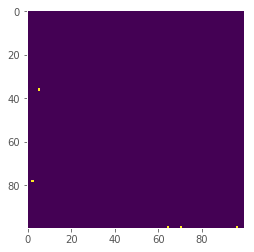

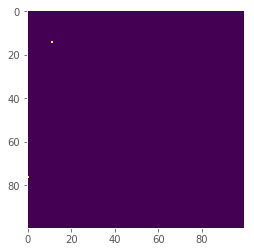

In [33]:
i = 4
img = (pred[i][:,:,1] > 0.5).reshape(-1, SIZE)
plt.grid()
plt.imshow(img.cpu())
plt.show()
plt.grid()
plt.imshow(labels[i][:,:,1].reshape(-1, SIZE).cpu())